#  Teeth Classification

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,load_img, img_to_array
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from collections import Counter
import time
from PIL import Image
import cv2

# Loading data


dict_values([480, 450, 360, 540, 324, 540, 393])
dict_values([160, 149, 120, 180, 108, 180, 131])
dict_values([160, 149, 120, 180, 108, 180, 131])


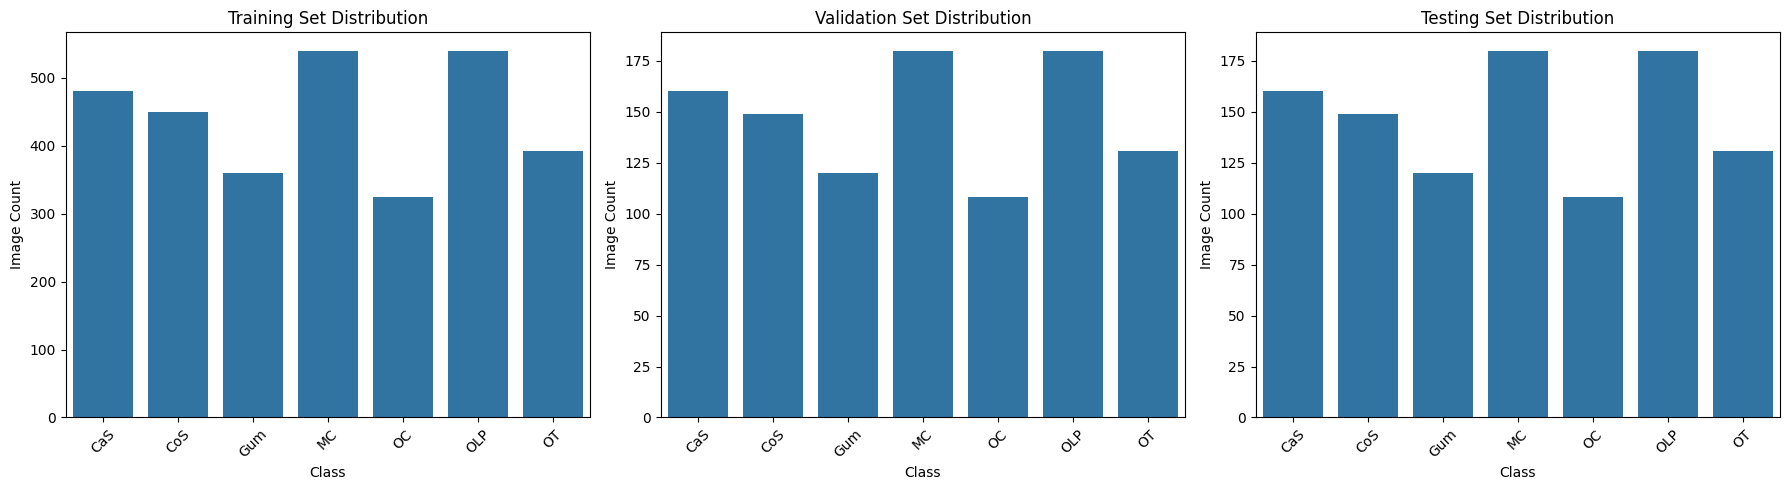

In [37]:
img_size = (224, 224)
batch_size = 16

data_dir = os.path.join(os.path.dirname(os.getcwd()), 'Teeth_Dataset')
train_dir = os.path.join(data_dir, 'Training')
valid_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'Testing')


splits = ['Training', 'Validation', 'Testing']

all_class_counts = {}

for split in splits:
    split_path = os.path.join(data_dir, split)
    class_counts = {}
    
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            img_files = [
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            class_counts[class_name] = len(img_files)
    
    all_class_counts[split] = class_counts
    print(class_counts.values())

plt.figure(figsize=(18, 5))

for i, split in enumerate(splits):
    plt.subplot(1, 3, i + 1)
    counts = all_class_counts[split]
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(f"{split} Set Distribution")
    plt.xlabel("Class")
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
    

# Data Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(    rescale=1./255,
                                        rotation_range=20,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.1,
                                        brightness_range=[0.8, 1.2],
                                        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   target_size=img_size,
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size=img_size,
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


# Visualizion the Augmentation Effect

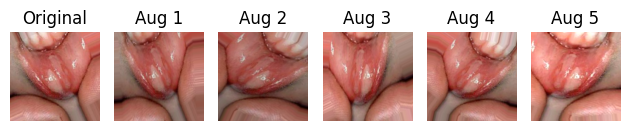

In [39]:

img_path = r"..\Teeth_Dataset\Training\CaS\a_79_0_707.jpg"
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Show original
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

for i, batch in enumerate(train_datagen.flow(img_array, batch_size=1)):
    plt.subplot(1, 6, i + 2)
    plt.imshow(batch[0])
    plt.title(f"Aug {i+1}")
    plt.axis('off')
    if i == 4:
        break
plt.tight_layout()
plt.show()

# Model Building 

In [40]:
model = Sequential([
    Conv2D(64, (5,5), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(64, (5,5), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Dropout(0.25),

    
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Dropout(0.25),
    
    Conv2D(256, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Conv2D(256, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Dropout(0.25),
    
    Conv2D(512, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Conv2D(512, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(256, activation='relu'),

    Dense(7, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 220, 220, 64)      4864      
                                                                 
 conv2d_56 (Conv2D)          (None, 216, 216, 64)      102464    
                                                                 
 batch_normalization_20 (Bat  (None, 216, 216, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 108, 108, 64)     0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 108, 108, 64)      0         
                                                                 
 conv2d_57 (Conv2D)          (None, 106, 106, 128)    

In [41]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Optional: show device names
tf.config.list_physical_devices()


TensorFlow version: 2.10.0
Num GPUs Available: 1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Model Training

In [42]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=50,  
        validation_data=valid_generator,
        callbacks=[early_stop]
    )


Epoch 1/50
193/193 [==============================] - 94s 443ms/step - loss: 3.3392 - accuracy: 0.2893 - val_loss: 4.1740 - val_accuracy: 0.2043
Epoch 2/50
193/193 [==============================] - 83s 427ms/step - loss: 3.0775 - accuracy: 0.3469 - val_loss: 4.9362 - val_accuracy: 0.1877
Epoch 3/50
193/193 [==============================] - 82s 423ms/step - loss: 2.9262 - accuracy: 0.4030 - val_loss: 3.4404 - val_accuracy: 0.2510
Epoch 4/50
193/193 [==============================] - 79s 410ms/step - loss: 2.7772 - accuracy: 0.4535 - val_loss: 3.4816 - val_accuracy: 0.2121
Epoch 5/50
193/193 [==============================] - 79s 409ms/step - loss: 2.6324 - accuracy: 0.4888 - val_loss: 2.6768 - val_accuracy: 0.4377
Epoch 6/50
193/193 [==============================] - 79s 410ms/step - loss: 2.4701 - accuracy: 0.5306 - val_loss: 2.6382 - val_accuracy: 0.4475
Epoch 7/50
193/193 [==============================] - 79s 408ms/step - loss: 2.3455 - accuracy: 0.5556 - val_loss: 2.4566 - val_ac

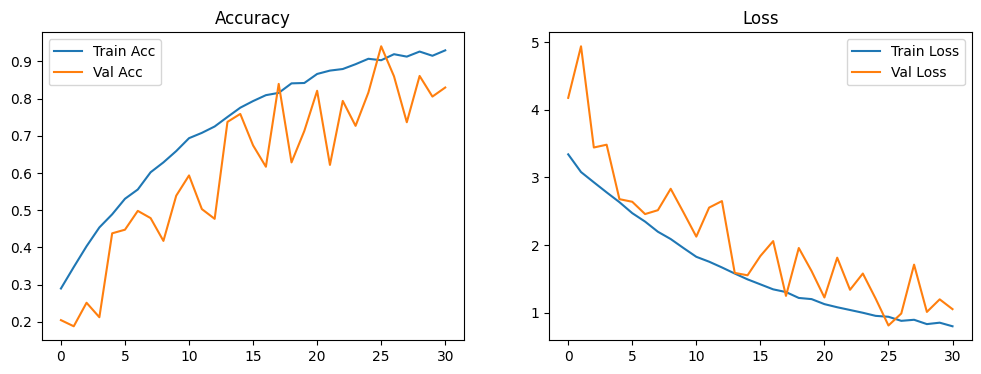

In [43]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


# Model Evaluation

65/65 [==============================] - 6s 90ms/step
Classification Report:

              precision    recall  f1-score   support

         CaS       0.95      0.99      0.97       160
         CoS       0.97      0.99      0.98       149
         Gum       0.88      1.00      0.94       120
          MC       0.96      0.88      0.92       180
          OC       0.97      0.94      0.96       108
         OLP       0.93      0.93      0.93       180
          OT       0.97      0.91      0.94       131

    accuracy                           0.95      1028
   macro avg       0.95      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028

Confusion Matrix:


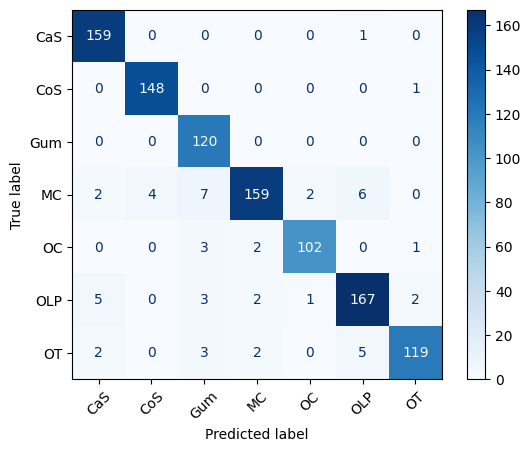

In [44]:
pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

y_true = test_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=counts.keys()))

cm = confusion_matrix(y_true, y_pred)

# Display as text
print("Confusion Matrix:")


# Display as a color-coded heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=counts.keys())
disp.plot(cmap='Blues', xticks_rotation=45)

In [45]:
model.save('teeth_model.h5', save_format='h5')